In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import cv2
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

tf.keras.mixed_precision.set_global_policy('mixed_float16')

In [3]:
train_dataset_path = 'dataset/test'
validation_dataset_path = 'dataset/test'

In [5]:
IMG_WIDTH = 150
IMG_HEIGHT = 150
BATCH_SIZE = 32

In [6]:
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                  zoom_range=0.2,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(train_dataset_path,
                                                   target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                   batch_size=BATCH_SIZE,
                                                   class_mode='categorical',
                                                   shuffle=True)

Found 697 images belonging to 7 classes.


In [7]:
validation_datagen = ImageDataGenerator(rescale=1.0/255)
validation_generator = validation_datagen.flow_from_directory(validation_dataset_path,
                                                             target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                             batch_size=BATCH_SIZE,
                                                             class_mode='categorical',
                                                             shuffle=True)

Found 697 images belonging to 7 classes.


In [8]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : Bacterial Red disease
1 : Bacterial diseases - Aeromoniasis
2 : Bacterial gill disease
3 : Fungal diseases Saprolegniasis
4 : Healthy Fish
5 : Parasitic diseases
6 : Viral diseases White tail disease


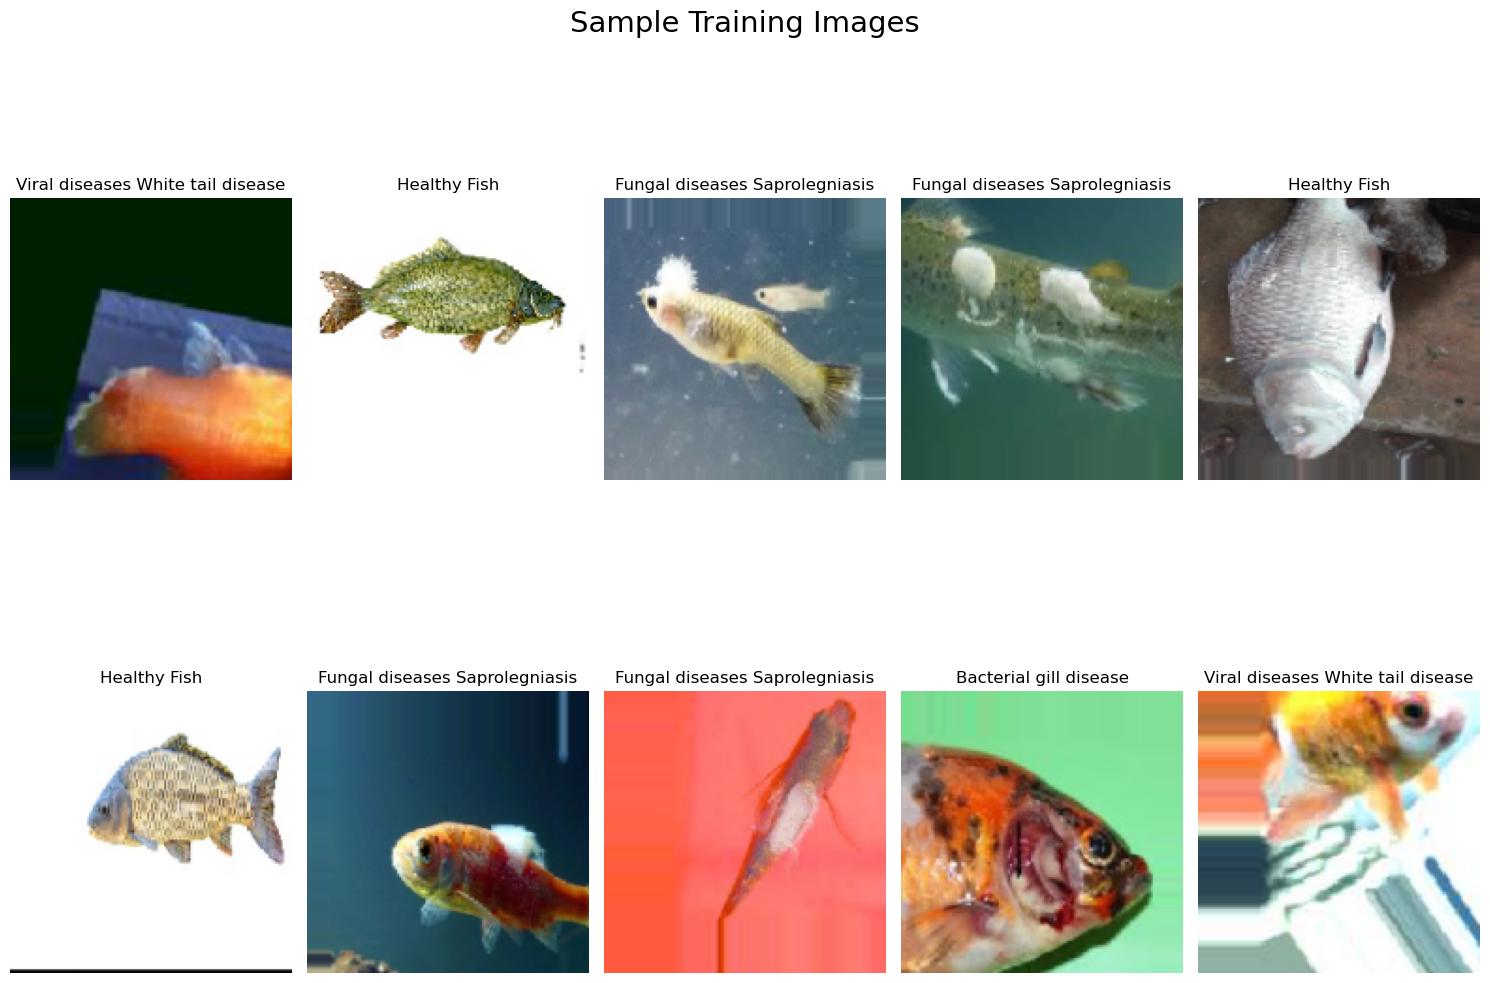

In [9]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 12))
idx = 0

for i in range(2):
    for j in range(5):
        label = labels[np.argmax(train_generator[0][1][idx])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_generator[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Sample Training Images", fontsize=21)
plt.show()

In [10]:
def create_model():
    model = Sequential(
        [
            Conv2D(
                filters=128,
                kernel_size=(5, 5),
                padding="valid",
                input_shape=(IMG_WIDTH, IMG_HEIGHT, 3),
            ),
            Activation("relu"),
            MaxPooling2D(pool_size=(2, 2)),
            BatchNormalization(),
            Conv2D(
                filters=64,
                kernel_size=(3, 3),
                padding="valid",
                kernel_regularizer=l2(0.00005),
            ),
            Activation("relu"),
            MaxPooling2D(pool_size=(2, 2)),
            BatchNormalization(),
            Conv2D(
                filters=32,
                kernel_size=(3, 3),
                padding="valid",
                kernel_regularizer=l2(0.00005),
            ),
            Activation("relu"),
            MaxPooling2D(pool_size=(2, 2)),
            BatchNormalization(),
            Flatten(),
            Dense(units=256, activation="relu"),
            Dropout(0.5),
            Dense(units=7, activation="softmax"),
        ],
        name="FishNet",
    )

    return model

In [11]:
cnn_model = create_model()
cnn_model.summary()

Model: "FishNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 146, 146, 128)  │         9,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 146, 146, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 73, 73, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 73, 73, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 71, 71, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 71, 71, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 35, 35, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 35, 35, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 33, 33, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 33, 33, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,202,087 (8.40 MB)

 Trainable params: 2,201,639 (8.40 MB)

 Non-trainable params: 448 (1.75 KB)

In [12]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)

In [13]:
optimizer = Adam(learning_rate=0.001)

In [14]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=10,
    verbose=1,
    mode='min',
    restore_best_weights=True
)

In [15]:
callbacks = [reduce_lr, early_stopping]

In [16]:
cnn_model.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=['accuracy', "mae"])

In [17]:
history = cnn_model.fit(train_generator, epochs=50, validation_data=validation_generator,
                       verbose=1,
                       callbacks=callbacks)

Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 435ms/step - accuracy: 0.1386 - loss: 3.4829 - mae: 0.2426 - val_accuracy: 0.1291 - val_loss: 2.0930 - val_mae: 0.2431 - learning_rate: 0.0010
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 339ms/step - accuracy: 0.2291 - loss: 4.9352 - mae: 0.2234 - val_accuracy: 0.1851 - val_loss: 3.0420 - val_mae: 0.2370 - learning_rate: 0.0010
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 344ms/step - accuracy: 0.3020 - loss: 5.0767 - mae: 0.2006 - val_accuracy: 0.1621 - val_loss: 3.3106 - val_mae: 0.2409 - learning_rate: 0.0010
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 331ms/step - accuracy: 0.3046 - loss: 4.6308 - mae: 0.2031 - val_accuracy: 0.1980 - val_loss: 2.7821 - val_mae: 0.2320 - learning_rate: 0.0010
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 336ms/step - accuracy: 0.2993 - loss: 4.3882 - mae: 0.2020 - val_accuracy: 0.1779 - val_loss: 2.7303 - val_mae: 0.2347 - learning_rate: 0.0010
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 330ms/step - accuracy: 0.3769 - loss: 

In [ ]:
# cnn_model.save('FishNet.keras')

In [18]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

# learning_rate = history.history['lr']

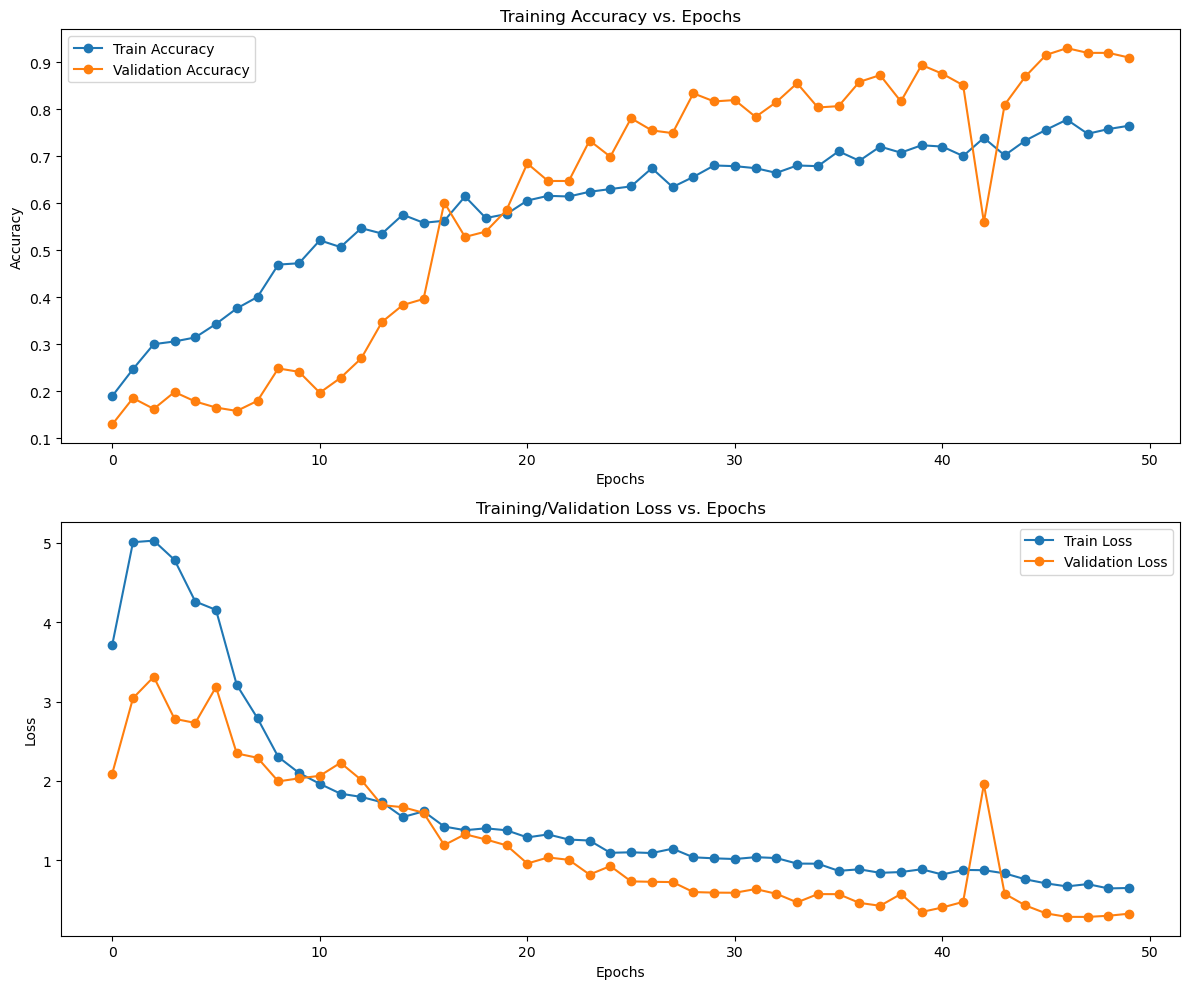

In [19]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

# ax[2].set_title('Learning Rate vs. Epochs')
# ax[2].plot(learning_rate, 'o-', label='Learning Rate')
# ax[2].set_xlabel('Epochs')
# ax[2].set_ylabel('Loss')
# ax[2].legend(loc='best')

plt.tight_layout()
plt.show()

In [20]:
test_dataset = 'dataset/test'

In [21]:
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(test_dataset,
                                                 shuffle=False,
                                                 batch_size=BATCH_SIZE,
                                                 target_size = (IMG_WIDTH, IMG_HEIGHT),
                                                 class_mode='categorical')

Found 697 images belonging to 7 classes.


In [22]:
predictions = cnn_model.predict(test_generator)

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step


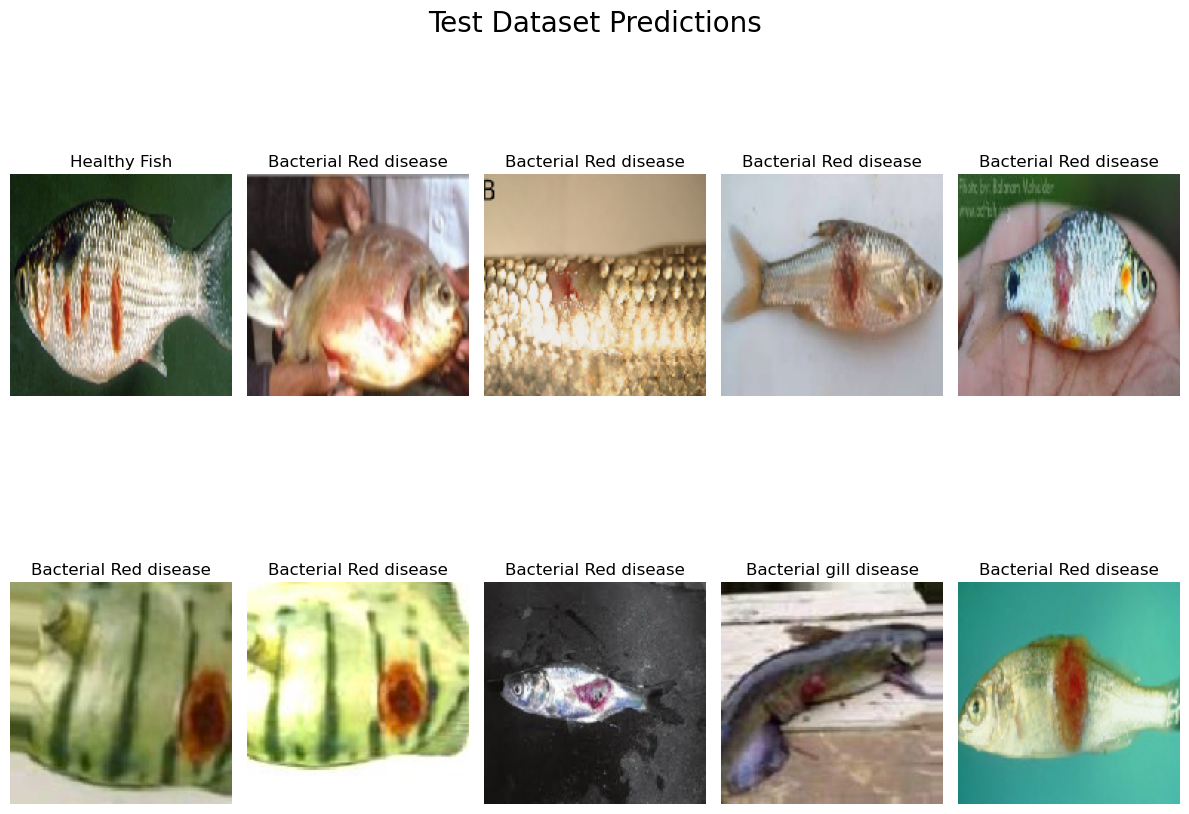

In [23]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        predicted_label = labels[np.argmax(predictions[idx])]
        ax[i, j].set_title(f"{predicted_label}")
        ax[i, j].imshow(test_generator[0][0][idx])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Test Dataset Predictions", fontsize=20)
plt.show()

In [27]:
test_loss, test_accuracy, test_mae = cnn_model.evaluate(test_generator, batch_size=BATCH_SIZE)

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.9182 - loss: 0.3182 - mae: 0.0556


In [28]:
print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test MAE:      {test_mae}")

Test Loss:     0.2887517511844635
Test Accuracy: 0.9296987056732178
Test MAE:      0.050832342356443405


In [29]:
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

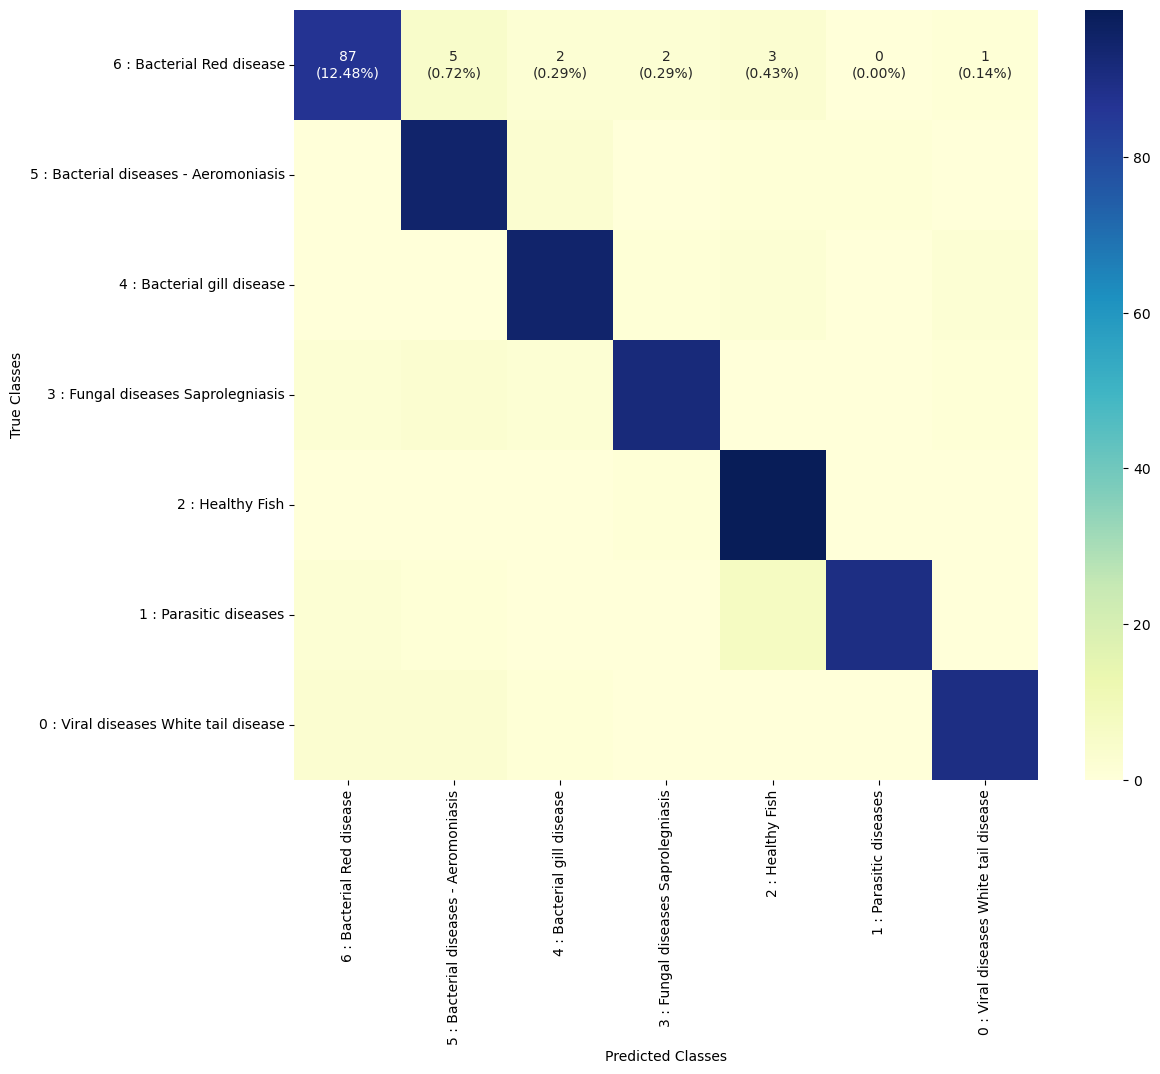

In [30]:
cf_mtx = confusion_matrix(y_true, y_pred)

group_counts = ["{0:0.0f}".format(value) for value in cf_mtx.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_mtx.flatten()/np.sum(cf_mtx)]
box_labels = [f"{v1}\n({v2})" for v1, v2 in zip(group_counts, group_percentages)]
box_labels = np.asarray(box_labels).reshape(7, 7)  # Assuming cf_mtx is 7x7 based on your previous message

plt.figure(figsize = (12, 10))
sns.heatmap(cf_mtx, annot=box_labels, fmt="", cmap="YlGnBu", xticklabels=['6 : Bacterial Red disease', '5 : Bacterial diseases - Aeromoniasis', '4 : Bacterial gill disease', '3 : Fungal diseases Saprolegniasis', '2 : Healthy Fish', '1 : Parasitic diseases', '0 : Viral diseases White tail disease'], yticklabels=['6 : Bacterial Red disease', '5 : Bacterial diseases - Aeromoniasis', '4 : Bacterial gill disease', '3 : Fungal diseases Saprolegniasis', '2 : Healthy Fish', '1 : Parasitic diseases', '0 : Viral diseases White tail disease'])
  # Adjusted to use labels directly
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.show()


In [31]:
from sklearn.metrics import classification_report

# Example usage
print(classification_report(y_true, y_pred, target_names=['Bacterial Red disease', 'Bacterial diseases - Aeromoniasis', 'Bacterial gill disease', 'Fungal diseases Saprolegniasis', 'Healthy Fish', 'Parasitic diseases', 'Viral diseases White tail disease'])) 

                                   precision    recall  f1-score   support

            Bacterial Red disease       0.93      0.87      0.90       100
Bacterial diseases - Aeromoniasis       0.89      0.95      0.92       100
           Bacterial gill disease       0.92      0.95      0.94       100
   Fungal diseases Saprolegniasis       0.96      0.92      0.94       100
                     Healthy Fish       0.88      0.99      0.93       100
               Parasitic diseases       0.99      0.90      0.94       100
Viral diseases White tail disease       0.96      0.93      0.94        97

                         accuracy                           0.93       697
                        macro avg       0.93      0.93      0.93       697
                     weighted avg       0.93      0.93      0.93       697



In [32]:
errors = (y_true - y_pred != 0)
y_true_errors = y_true[errors]
y_pred_errors = y_pred[errors]

In [33]:
test_images = test_generator.filenames
test_img = np.asarray(test_images)[errors]

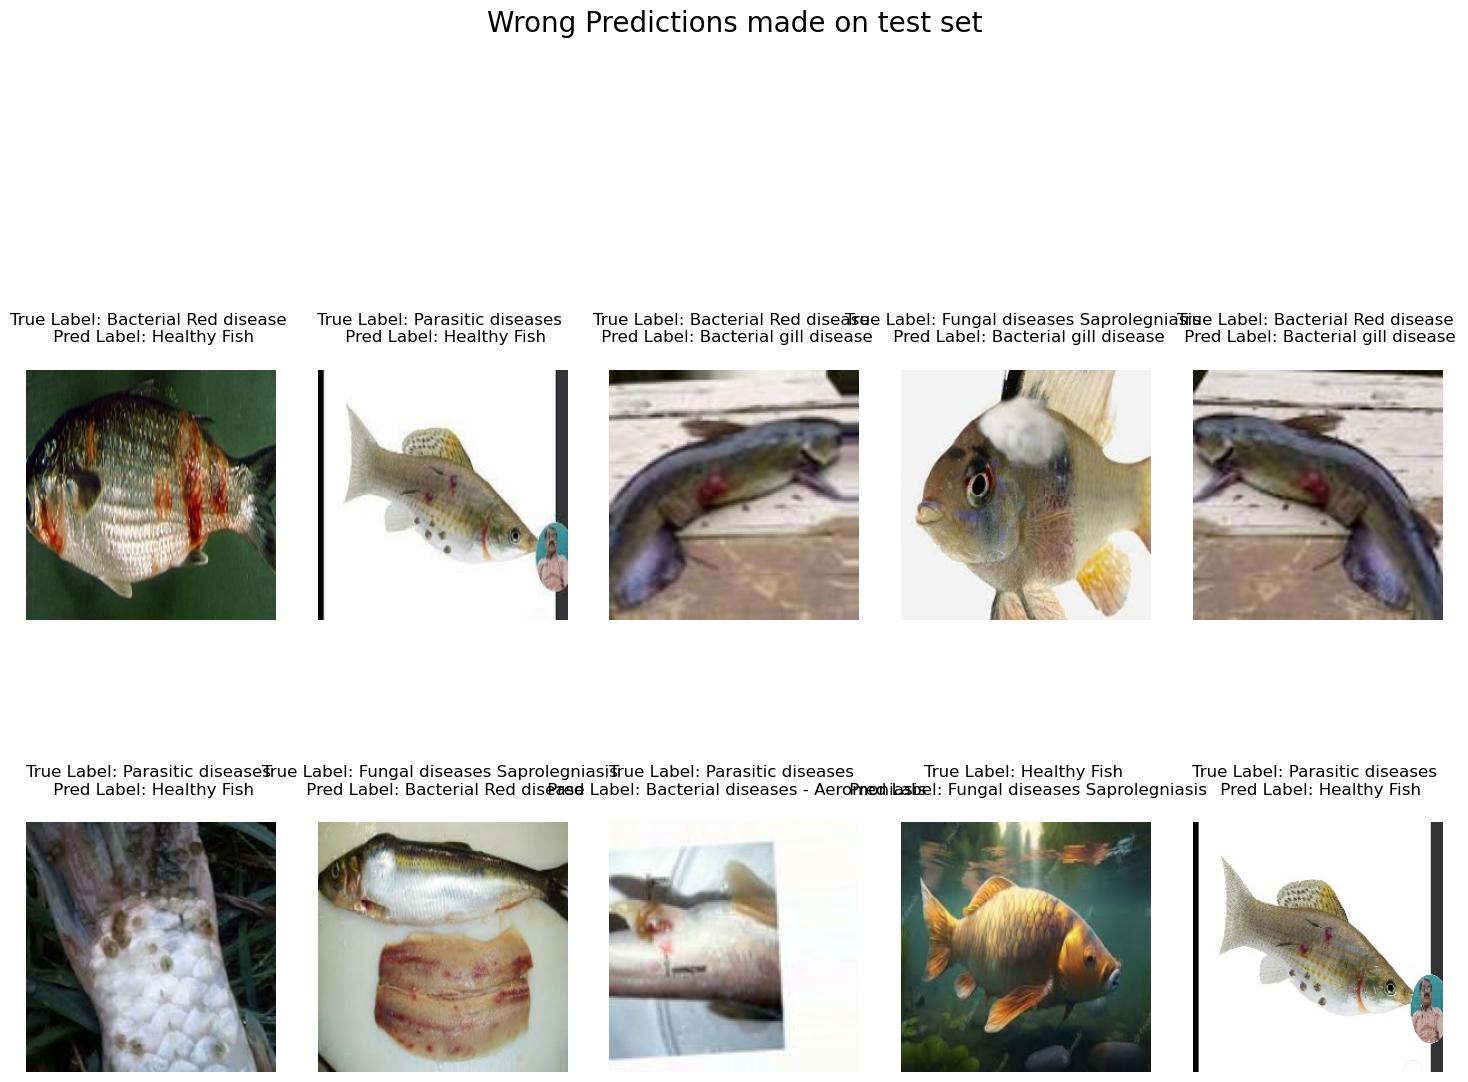

In [34]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 12))  # Adjusted figsize

for i in range(2):
    for j in range(5):
        idx = np.random.randint(0, len(test_img))
        true_index = y_true_errors[idx]
        true_label = labels[true_index]
        predicted_index = y_pred_errors[idx]
        predicted_label = labels[predicted_index]
        title_text = f"True Label: {true_label} \n Pred Label: {predicted_label}"
        ax[i, j].set_title(title_text, pad=20)  # Adjusted padding for title
        img_path = os.path.join(test_dataset, test_img[idx])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax[i, j].imshow(img)
        ax[i, j].axis("off")

plt.tight_layout(pad=3.0)  # Adjusted padding
plt.subplots_adjust(top=0.88)  # Adjust top spacing to fit suptitle
plt.suptitle('Wrong Predictions made on test set', fontsize=20, y=1.05)  # Adjusted y for suptitle
plt.show()


In [35]:
cnn_model.save("FishNet.keras")